In [42]:
# First going to work out some ideas in a jupyter notebook - Later I will clean this
# up and and create some proper code.

from typing import Iterator, NamedTuple

# Getting some tensorflow warnings, but don't care about those right now
#import warnings
#warnings.filterwarnings('ignore')

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import pathlib
import string
import glob2
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp

import matplotlib.pyplot as plt

import dataclasses

In [18]:
# The IAM On-Line Handwriting Database (IAM-OnDB) is required for this project, so you will need to ask for
# permission for that and download. https://fki.tic.heia-fr.ch/databases/iam-on-line-handwriting-database 
# Here we will create a wrapper class to give us some tensorflow dataset summaries of just the writing portion.

class WritingGenerator():
    def __init__(self, f_name, batch_size=32):   
        self.all_x = []
        self.all_y = []

        # How we might pad each stroke to a consistent length and batch it for fitting - With the amount 
        # of data in the database and the complexity of a Transformer, this should probably be kept to
        # under 400 strokes and 20 characters. There is an issue here though that different people use 
        # different amounts of strokes/char and this can confuse the network. I am not sure there is an
        # elegant way to handle that problem with a Transformer network, as we would need about 1500
        # tokens to read in every writing sample fully with padding and this is beyond a standard 
        # Transformer. Perhaps a PerceiverAR is next?
        self.MAX_STROKE_LEN = 100
        self.MAX_CHAR_SEQ_LEN = 7         
        
        self.f_name = f_name
        
        self.batch_size = batch_size
        
        self.padding_value = -1.
        self.char_padding_value = 0.

        # You will need to change this and point to your own database where you unzipped all of the 
        # IAM-OnDB strokes and corresponding ascii
        base_dir_strokes='../IamONDB/lineStrokes'
        base_dir_ascii='../IamONDB/ascii'
        
        try:
            f = open(f_name, 'r')
        except IOError:
            print("Error opening file")
            return 0
      
        f_train = list(f)
        f.close()
        
        self.n_samp = len(f_train)

        print('Reading ' + str(self.n_samp) + ' files')

        # This will contain a list of all stroke files
        self.f_sub_list_strokes = []
        # This will contain a list of corresponding ascii line files
        self.f_sub_list_ascii = []

        # First create a list of all subfiles in the .txt list - we are going to treat each line as a separate sample here
        for i, fname in enumerate(f_train):
            path_stroke = glob2.glob(base_dir_strokes + '/' + fname.strip()[0:3] + '/' + fname.strip()[0:7] + '/' + fname.strip() + '-*.xml')    
              
            self.f_sub_list_strokes += path_stroke

            path_line = glob2.glob(base_dir_ascii + '/' + fname.strip()[0:3] + '/' + fname.strip()[0:7] + '/' + fname.strip() + '.txt')   
            # We want a 1 to 1 matching of strokes to ascii.  We will pull out the appropriate line when we create the dataset
            self.f_sub_list_ascii += path_line * len(path_stroke)
                        
        # list datasets
        self.list_ds_strokes = tf.data.Dataset.from_tensor_slices(self.f_sub_list_strokes)
        self.list_ds_ascii = tf.data.Dataset.from_tensor_slices(self.f_sub_list_ascii)

        # Text helper functions and variables.  All lines of text need to be one-hot-encoded for proper integration into the attention
        # mechanism of the model
        self.vocab = string.printable

        # I am adding 1 to all character enumerations so that 0 is reserved for padding only and can be ignored in the model
        self.char2idx = {u: i+1 for i, u in enumerate(self.vocab)}
        self.idx2char = {i+1: u for i, u in enumerate(self.vocab)}

        self.invert_one_hot = lambda x: tf.argmax(x, -1).numpy()

        self.text_to_int = lambda x: np.array([self.char2idx[c] for c in x])
        self.int_to_text = lambda x: ''.join(np.array([self.idx2char[i] for i in x]))

        # Combine
        self.list_ds = tf.data.Dataset.zip((self.list_ds_strokes, self.list_ds_ascii))
        
        # Create a datbase of tuples (strokes, matching ascii)
        self.labeled_ds = self.list_ds.map(lambda x, y: tf.py_function(self.process_stroke, (x, y), (tf.float32, tf.float32)))
        
        self.cached_example_dataset = self.labeled_ds.shuffle(buffer_size=1024).cache().take(1024)
        
    # Create a dataset of strokes and matching lines - As mentioned before, each line is a training sample in this version
    def process_stroke(self, file_path_stroke, file_path_lines):
        line_num = int(file_path_stroke.numpy()[-6:-4])
        strokes = self.get_strokes(file_path_stroke.numpy())
        # Not sure the best way to combine two files
        lines = self.get_ascii(file_path_lines)

        U = lines[line_num-1]
        U = U[:self.MAX_CHAR_SEQ_LEN]
        U_conv = tf.keras.backend.one_hot(self.text_to_int(U), len(self.vocab)+1)

        return strokes, U_conv

    # Returns only the strokes of the dataset as a tuple with a label of the same data 1 timestamp ahead
    @property
    def batched_set(self):
        # We don't care about the line data for this version, so remove that first

        stroke_only_ds=self.labeled_ds.map(lambda x, y: x)
        
        # All sequences will be strictly right padded so that tensorflow will run them on a GPU
        batched_dataset = stroke_only_ds.padded_batch(self.batch_size, padded_shapes=([self.MAX_STROKE_LEN, 3]), 
                                                      drop_remainder=True, padding_values=self.padding_value)

        return batched_dataset.map(self.dense_1_step).cache()
        return batched_dataset.cache()

    # Returns only the strokes of the dataset as a tuple with a label of the same data 1 timestamp ahead
    # This one also returns the character sequence U being written as a one-hot-encoded tensor
    @property
    def batched_onehot_set(self):
        batched_dataset_one_hot = self.labeled_ds.padded_batch(
            self.batch_size, padded_shapes=([self.MAX_STROKE_LEN, 3], 
                                            [self.MAX_CHAR_SEQ_LEN, len(self.vocab)+1]), 
                                            drop_remainder=False, padding_values=(self.padding_value, self.char_padding_value))        

        return batched_dataset_one_hot.map(self.dense_1_step)

    # We will make our prediction 1 step ahead
    def dense_1_step(self, batch_stroke, batch_char_seq):
        # Shift features and labels one step relative to each other.
        return (batch_stroke[:, :, :], batch_char_seq ), batch_stroke[:, :, :]
    
    def get_examples(self, num_examples):
        example_dataset = self.labeled_ds.shuffle(100).take(num_examples)
        
        #example_dataset = self.labeled_ds.batch(1).shuffle(100).take(num_examples)
        
        return example_dataset
        
    def get_strokes(self, fname):
        root = ET.parse(fname).getroot()

        # Parse one xml file
        strokeset = root.find('StrokeSet')

        x_samp = []

        for stroke in strokeset.iter('Stroke'):
            for child in stroke:
                x_samp.append([float(child.attrib.get('x')), -1*float(child.attrib.get('y')), 0.])

            # As in Graves, 2013, we add a binary vector indicating the end of a stroke
            x_samp[-1][-1]=1.0

        x_samp = np.asarray(x_samp)
        x_samp = x_samp[:self.MAX_STROKE_LEN, :]

        # We want the data as offsets though, not raw strokes - easier to train a network to predict small changes in the next timestamp
        x_off = np.hstack(([x_samp[1:, :2]-x_samp[:-1, :2], x_samp[1:, 2:3]]))
        x_off = np.vstack(([0, 0, 0], x_off))

        x_off[:, 0] /= np.std(x_off[:, 0])
        x_off[:, 1] /= np.std(x_off[:, 1])

        return x_off
 
    # Read an ascii file form the iamONDB and return all of the lines as strings
    def get_ascii(self, fname):
        text_file = open(fname.numpy(), "r")
        lines = text_file.read()
        lines = lines.split('CSR:')

        return lines[1].strip().split('\n')       
    
    def __repr__(self):
        return '\n'.join([
            f'Writing Dataset for: {self.f_name}'
        ])

In [19]:
# Drawing function for strokes
# TODO: This should be in the writing class

def plot_stroke(offsets, lines):
    plt.figure(num=None, figsize=(15, 4))
    strokes=np.array([np.cumsum(offsets[:,0]), np.cumsum(offsets[:,1]), offsets[:,2]]);    
    stroke=[]

    strokes[-1, -1] = 1

    for x, y, eos in strokes.T:
        stroke.append([x, y])
        if eos > 0.1:
            stroke=np.asarray(stroke);
            #print(stroke.shape)
            plt.plot(stroke[:,0], stroke[:,1], 'k')
            stroke = []

    clean_txt = lines.numpy()

    clean_txt = np.delete(clean_txt, np.argmax(clean_txt, -1) == 0.0, axis=0)

    # TODO: This should be passed in
    plt.title(train.int_to_text(train.invert_one_hot(clean_txt)))

    plt.show()

In [20]:
# I concatenated all data into one set as we just want the maximum amount of data to train the 
# network to write and don't really care about evaluation or test sets for this project
train = WritingGenerator('../IamONDB/trainset_d.txt')

Reading 1726 files


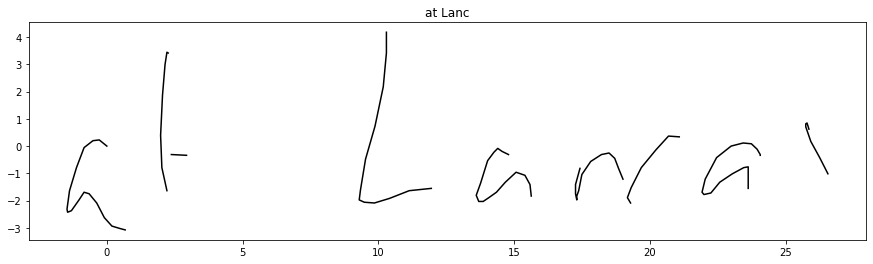

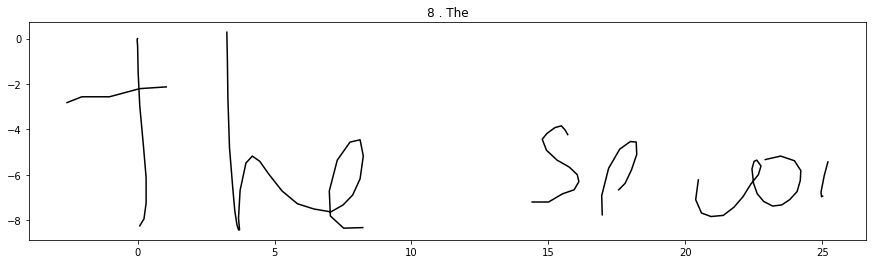

In [21]:
# Inspect our dataset.  It returns a tuple of stroke offsets and matching ascii strings
# You can see that there isn't an exact match for every subject for strokes to ascii 
# because of the token limit in Transformers
SUB = 1

for s, l in train.batched_onehot_set.take(2).cache():
    plot_stroke(s[0][SUB, :, :], s[1][SUB, :])

In [22]:
# Much of the following code is from the excellent Tensorflow tutorial on Transformers: https://www.tensorflow.org/text/tutorials/transformer

# STEP 1 - Positional Embeddings from the original paper. Although, you can also just add a randomized vector and I may try that next
# TODO: Switch to a random vector and see if performance suffers vs this complex embedding.

def get_angles(pos, i, d_model):
  angle_rates = 1 / jnp.power(10000, (2 * (i//2)) / jnp.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(jnp.arange(position)[:, jnp.newaxis],
                          jnp.arange(d_model)[jnp.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads = angle_rads.at[:, 0::2].set(jnp.sin(angle_rads[:, 0::2]))

  # apply cos to odd indices in the array; 2i+1
  angle_rads = angle_rads.at[:, 1::2].set(jnp.cos(angle_rads[:, 1::2]))

  pos_encoding = angle_rads[jnp.newaxis, ...]

  return pos_encoding

In [39]:
# Build up some pieces in haiku. See: https://github.com/deepmind/dm-haiku/tree/main/examples/transformer

def layer_norm(x: jnp.ndarray) -> jnp.ndarray:
  """Applies a unique LayerNorm to x with default settings."""
  ln = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
  return ln(x)

def point_wise_feed_forward(x: jnp.ndarray, d_model: int, dff: int) -> jnp.ndarray:
  mlp = hk.Sequential([
      hk.Linear(dff, name='Lin1'), jax.nn.relu, # (batch_size, seq_len, dff)
      hk.Linear(d_model, name='Lin2'),          # (batch_size, seq_len, d_model)
  ])
  return mlp(x)

In [40]:
# Test out the point_wise_feed_forward network
network = hk.transform(point_wise_feed_forward)
params = network.init(rng=jax.random.PRNGKey(42), x=jnp.zeros((32, 100)), d_model=128, dff=128)

In [53]:
# The Encoder - Self attention over the input characters
class Encoder_Layer(hk.Module):
    # The Encoder Layer is one stack of the Encoder, putting the multihead together 
    # with the point wise network and some normalization layers
    def __init__(self, key_size, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__(name='EncoderLayer')

        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        # In haiku the key_size is specified manually instead of d_model/num_heads. Internally, it 
        # will project Q, K, and V to dimensions (*leading_dims, num_heads, head_size) before 
        # computing attention logits. After that you can futher modify it to project to d_model.
        # TODO: Define an initializer here?
        self.mha = hk.MultiHeadAttention(num_heads=num_heads, key_size=key_size, model_size=d_model, w_init_scale=1)

    # I don't think haiku has any method for dealing with removing dropout automatically, so we will need
    # to always pass in a training flag to remove it if necessary during inference
    def __call__(
        self,
        x: jnp.ndarray,
        mask,
        training=True
    ) -> jnp.ndarray:
        attn_out = self.mha(x, x, x, mask)
        if training:
            attn_out = hk.dropout(hk.next_rng_key(), self.dropout_rate, attn_out)

        attn_out = point_wise_feed_forward(attn_out, self.d_model, self.dff)

        return attn_out


In [55]:
# Test Encoder
def encoder(x: jnp.ndarray, mask: jnp.ndarray) -> jnp.ndarray:
    enc = Encoder_Layer(32, 128, 4, 128)

    return enc(x, mask)

network = hk.transform(encoder)
params = network.init(rng=jax.random.PRNGKey(42), x=jnp.zeros((1, 100)), mask=jnp.zeros((1, 100)))

ValueError: Mask dimensionality 2 must match logits 3.